In [63]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud

import isodate
import ast
import re
from unidecode import unidecode

import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from keybert import KeyBERT
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sentence_transformers import SentenceTransformer




# Import necessary libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns


# Import necessary libraries for data selection
from sklearn.feature_selection import chi2

# Import library for data splitting
from sklearn.model_selection import train_test_split

# Import necessary libraries for data modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor, Pool

from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import shap

import requests
import os
from tqdm import tqdm
import cv2
import easyocr

In [2]:
df = pd.read_csv('new_programming_org.csv', parse_dates=['fetching_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fetching_date         2408 non-null   datetime64[ns]
 1   trending_country      2408 non-null   object        
 2   video_id              2408 non-null   object        
 3   video_title           2408 non-null   object        
 4   video_published_at    2408 non-null   object        
 5   video_description     1770 non-null   object        
 6   channel_id            2408 non-null   object        
 7   channel_title         2408 non-null   object        
 8   tags                  2408 non-null   object        
 9   category_id           2408 non-null   int64         
 10  default_language      2408 non-null   object        
 11  duration              2408 non-null   object        
 12  dimension             2408 non-null   object        
 13  definition        

In [3]:
def extract_topics(text):
    if not isinstance(text, str):
        return ''
    topics = re.findall(r'wiki/([^\'",\]]+)', text)
    return ', '.join(topics)

df['topic_categories'] = df['topic_categories'].apply(extract_topics)


In [5]:
def data_cleaning(df):
    # Remove duplicates
    hashable_cols = [col for col in df.columns if col not in ['tags', 'topic_categories']]
    df_clean = df.drop_duplicates(subset=hashable_cols)

    # Handle missing values
    key_columns = [
                    'video_id',
                    'video_title', 
                    'video_view_count', 
                    'video_like_count', 
                    'video_comment_count',
                    'video_count', 
                    'subscriber_count', 
                    'channel_view_count'
                ]
    df_clean = df_clean.dropna(subset=key_columns)

    # Remove entries with zero video_count, video_view_count, or channel_view_count
    df_clean = df_clean[(df_clean['video_count'] != 0) & (df_clean['video_view_count'] != 0) & (df_clean['channel_view_count'] != 0)]

    # Filter for English language videos
    df_clean = df_clean[df_clean['default_language'].str.startswith('en', na=False)]

    # Map category_id to category_title
    category_map = {
                    '1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'
                    }   

    # Process duration and category   
    df_clean['category_title'] = df_clean['category_id'].apply(lambda x: category_map[str(x)])
    df_clean['duration_min'] = df_clean['duration'].apply(
        lambda x: isodate.parse_duration(x).total_seconds()/60)
    # df_clean['is_high_definition'] = df_clean['definition'].apply(lambda x: 1 if x == 'hd' else 0)

    # Convert date columns to datetime
    df_clean['video_published_at'] = pd.to_datetime(df_clean['video_published_at'])
    df_clean['channel_published_at'] = df_clean['channel_published_at'].apply(lambda x: re.sub(r'\.\d+Z', 'Z', str(x)))
    df_clean['channel_published_at'] = pd.to_datetime(df_clean['channel_published_at']) 
    

    return df_clean

In [6]:
def normalize_text(text):
    if pd.isna(text):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    #  Remove Web links
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def additional_normalize_text(text):
    if pd.isna(text):
        return ''
    
    # Convert accented characters to their ASCII equivalents
    text = unidecode(text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text



def spcay_text(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and not token.is_punct]
    return ' '.join(tokens)


def normalize_text_columns(df, text_columns = ['video_title', 'video_description', 'channel_title', 'channel_description'], function=normalize_text):    
    for col in text_columns:
        df[col] = df[col].apply(function)
    return df

In [7]:
def sentiment_enginering(df):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_columns = ['video_title', 'video_description']
    for col in sentiment_columns:
        df[f'{col}_sentiment'] = df[col].apply(lambda x: analyzer.polarity_scores(x)["compound"])
        # df[f'has_emoji_in_{col}'] = df[col].apply(lambda x: 1 if any(char in emoji.EMOJI_DATA for char in x) else 0)
        df[f'count_of_emoji_in_{col}'] = df[col].apply(lambda x: sum(1 for char in x if char in emoji.EMOJI_DATA)) 
    return df

In [8]:
def model_feature_engineering(df):

    df['publishing_day'] = df['video_published_at'].apply(lambda x: pd.to_datetime(x).day_name())
    df['publishing_hour'] = df['video_published_at'].apply(lambda x: pd.to_datetime(x).hour)
    
    df['video_age_days'] = (pd.to_datetime(df['fetching_date'], utc=True) - pd.to_datetime(df['video_published_at'])).dt.total_seconds() / (24 * 3600)  
    df['channel_age_days'] = (pd.to_datetime(df['fetching_date'], utc=True) - pd.to_datetime(df['channel_published_at'])).dt.total_seconds() / (24 * 3600)  

    # df['has_tags'] = df['tags'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '[]' else 1)
    df['counts_of_tags'] = df['tags'].apply(lambda x: 0 if pd.isna(x) else len(ast.literal_eval(x)))
    # df['has_topic_categories'] = df['topic_categories'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)
    # df['counts_of_topic_categories'] = df['topic_categories'].apply(lambda x: 0 if pd.isna(x) else len(ast.literal_eval(x)))
    # df['has_video_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)
    # df['has_channel_description'] = df['channel_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)    
    df['word_count_in_title'] = df['video_title'].apply(lambda x: len(x.split()))
    df['word_count_in_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split()))
    df['word_count_in_channel_title'] = df['channel_title'].apply(lambda x: len(x.split())) 
    df['word_count_in_channel_description'] = df['channel_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split()))
    # df['character_count_in_title'] = df['video_title'].apply(lambda x: len(x))
    # df['character_count_in_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x))
    

    # df['title_sentiment_blob'] = df['video_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    # df['description_sentiment_blob'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else TextBlob(x).sentiment.polarity)
    df['engagement_rate'] = (df['video_like_count'] + df['video_comment_count']) / df['video_view_count']
    df['avg_weekly_posts'] = (df['video_count'] / df['channel_age_days'])*7

    return df


In [9]:
df.isnull().sum()
df = df.dropna(subset=['duration'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fetching_date         2408 non-null   datetime64[ns]
 1   trending_country      2408 non-null   object        
 2   video_id              2408 non-null   object        
 3   video_title           2408 non-null   object        
 4   video_published_at    2408 non-null   object        
 5   video_description     1770 non-null   object        
 6   channel_id            2408 non-null   object        
 7   channel_title         2408 non-null   object        
 8   tags                  2408 non-null   object        
 9   category_id           2408 non-null   int64         
 10  default_language      2408 non-null   object        
 11  duration              2408 non-null   object        
 12  dimension             2408 non-null   object        
 13  definition        

In [10]:
df = data_cleaning(df)
df = normalize_text_columns(df, function=normalize_text)
df = sentiment_enginering(df)

In [11]:
df['video_description'].apply(lambda x: '' if x.strip() == '' else x)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2153 entries, 0 to 2407
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   fetching_date                        2153 non-null   datetime64[ns]     
 1   trending_country                     2153 non-null   object             
 2   video_id                             2153 non-null   object             
 3   video_title                          2153 non-null   object             
 4   video_published_at                   2153 non-null   datetime64[ns, UTC]
 5   video_description                    2153 non-null   object             
 6   channel_id                           2153 non-null   object             
 7   channel_title                        2153 non-null   object             
 8   tags                                 2153 non-null   object             
 9   category_id                        

In [ ]:
df = normalize_text_columns(df, function=additional_normalize_text)

In [16]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
title_embeddings = embedding_model.encode(df['video_title'].tolist(), show_progress_bar=True)
description_embeddings = embedding_model.encode(df['video_description'].tolist(), show_progress_bar=True)   

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

In [19]:
title_embeddings_columns = [f'title_emb_{i}' for i in range(title_embeddings.shape[1])]
df_title_embeddings = pd.DataFrame(title_embeddings, columns=title_embeddings_columns)
description_embeddings_columns = [f'description_emb_{i}' for i in range(description_embeddings.shape[1])]
df_description_embeddings = pd.DataFrame(description_embeddings, columns=description_embeddings_columns)
df = pd.concat([df.reset_index(drop=True), df_title_embeddings.reset_index(drop=True), df_description_embeddings.reset_index(drop=True)], axis=1) 
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Columns: 800 entries, fetching_date to description_emb_383
dtypes: bool(2), datetime64[ns, UTC](2), datetime64[ns](1), float32(768), float64(5), int64(7), object(15)
memory usage: 6.8+ MB


In [20]:
df.shape

(2153, 800)

In [21]:
df.columns

Index(['fetching_date', 'trending_country', 'video_id', 'video_title',
       'video_published_at', 'video_description', 'channel_id',
       'channel_title', 'tags', 'category_id',
       ...
       'description_emb_374', 'description_emb_375', 'description_emb_376',
       'description_emb_377', 'description_emb_378', 'description_emb_379',
       'description_emb_380', 'description_emb_381', 'description_emb_382',
       'description_emb_383'],
      dtype='object', length=800)

In [22]:
df['spacy_title'] = df['video_title'].apply(spcay_text)

In [23]:
df[['spacy_title','video_title','video_description']]

,spacy_title,video_title,video_description
0,data structure vs algorithm explain 30 second ...,data structures vs algorithms explained in 30 ...,join our live 4 month jobready bootcamps full ...
1,c language project beginner source code mini p...,c language projects for beginners with source ...,struggling with your college project facing ch...
2,variable datatype rule syntax explain concept,variables datatypes their rules syntax explain...,unlock the secrets of c programming and take y...
3,program c c paper 2024 mayjune bcom computer a...,programming with c and c paper 2024 mayjune bc...,
4,understand oop,understanding oops,join our live 4 month jobready bootcamps full ...
...,...,...,...
2148,ai agent explain 60 simple concept analogy ai ...,ai agents explained in 60s simple concept anal...,unlock the world of ai agents in under a minut...
2149,c programming union concept sizeof question so...,c programming union concept sizeof question wi...,in this video i have tried to give answers to ...
2150,printf octal value imp concept clanguageinhind...,printf octal value imp concept clanguageinhind...,in this video i have tried to give c programmi...
2151,demonstrate concept structure c programming,to demonstrate the concept of structure in c p...,to demonstrate the concept of structure in c p...


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2153 entries, 0 to 2407
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   fetching_date                        2153 non-null   datetime64[ns]     
 1   trending_country                     2153 non-null   object             
 2   video_id                             2153 non-null   object             
 3   video_title                          2153 non-null   object             
 4   video_published_at                   2153 non-null   datetime64[ns, UTC]
 5   video_description                    2153 non-null   object             
 6   channel_id                           2153 non-null   object             
 7   channel_title                        2153 non-null   object             
 8   tags                                 2153 non-null   object             
 9   category_id                        

In [24]:
kw_model = KeyBERT(model='all-MiniLM-L6-v2')
def extract_keywords(text, kw_model=kw_model, top_n=2):
    if pd.isna(text) or text.strip() == '':
        return []
    keywords = kw_model.extract_keywords(text, top_n=top_n, stop_words='english')
    return [kw[0] for kw in keywords]
df['extracted_keywords'] = df['spacy_title'].apply(lambda x: extract_keywords(x, kw_model=kw_model, top_n=1))

In [26]:
df[['extracted_keywords','video_title']]

,extracted_keywords,video_title
0,[dsa],data structures vs algorithms explained in 30 ...
1,[code],c language projects for beginners with source ...
2,[datatype],variables datatypes their rules syntax explain...
3,[bcom],programming with c and c paper 2024 mayjune bc...
4,[oop],understanding oops
...,...,...
2148,[ai],ai agents explained in 60s simple concept anal...
2149,[union],c programming union concept sizeof question wi...
2150,[conceptualcoding],printf octal value imp concept clanguageinhind...
2151,[programming],to demonstrate the concept of structure in c p...


In [27]:
df.to_csv('embedding_programming_org.csv', index=False)

In [32]:
thumbnail_video_ids = df['video_id'].to_list()
print(len(thumbnail_video_ids))

2153


In [ ]:
API_KEY = 'xxxxx'
BASE_URL = "https://www.googleapis.com/youtube/v3"

In [37]:
video_list = []

for i in range(0, len(thumbnail_video_ids), 50):
    batch = thumbnail_video_ids[i:i+50]
    video_ids = ','.join(batch)
    params = {
        'part': 'snippet, contentDetails, statistics, topicDetails, status',
        'id': video_ids,
        'maxResults': 50,
        'regionCode': 'US', # Change region code as needed
        'key': API_KEY
        }
    
    response = requests.get(f"{BASE_URL}/videos", params=params)
    if response.status_code == 200:
        data = response.json()
    else:
        print("Error:", response.status_code, response.text)
        data = None
    
    if data:
        for item in (data.get('items', [])):
            video = {
            
                'video_id': item['id'],
                'video_title': item['snippet']['title'],
                
                'thumbnail_url': (item['snippet']['thumbnails'].get('high') 
                 or item['snippet']['thumbnails'].get('default') 
                 or {}).get('url', ''),
                'thumbnail_width': (item['snippet']['thumbnails'].get('high') 
                   or item['snippet']['thumbnails'].get('default') 
                   or {}).get('width', ''),
                'thumbnail_height': (item['snippet']['thumbnails'].get('high') 
                    or item['snippet']['thumbnails'].get('default') 
                    or {}).get('height', '')
            }
            video_list.append(video)
    else:
        print("No data fetched.")
   

dftv = pd.DataFrame(video_list)
file = f'thumbnail_videos.csv'
dftv.to_csv(file, index=False)
print(f" Saved serch videos to youtube_search_videos.csv")
    

 Saved serch videos to youtube_search_videos.csv


In [43]:
dftv.drop(columns=['video_title'], inplace=True)

In [45]:
df = pd.merge(df,dftv,on='video_id',how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Columns: 805 entries, fetching_date to thumbnail_height
dtypes: bool(2), datetime64[ns, UTC](2), datetime64[ns](1), float32(768), float64(7), int64(7), object(18)
memory usage: 6.9+ MB


In [46]:
# df = normalize_text_columns(df, function=additional_normalize_text)
dfoo = df.copy()
df = model_feature_engineering(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Columns: 816 entries, fetching_date to avg_weekly_posts
dtypes: bool(2), datetime64[ns, UTC](2), datetime64[ns](1), float32(768), float64(11), int64(13), object(19)
memory usage: 7.1+ MB


In [47]:
df.to_csv('20251130_programming_org.csv', index=False)

In [ ]:
download_folder = 'thumbnails'
os.makedirs(download_folder, exist_ok=True)

for index, row in tqdm(df.iterrows(), total=dftv.shape[0]):
    video_id = row['video_id']
    thumbnail_url = row['thumbnail_url']
    if pd.isna(thumbnail_url) or thumbnail_url.strip() == '':
        continue  
    
    response = requests.get(thumbnail_url, stream=True)
    if response.status_code == 200:
        file_path = os.path.join(download_folder, f"{video_id}.jpg")
        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
    else:
        print(f"Failed to download thumbnail for video ID {video_id}")
print("\nDownload process complete!")



2153it [08:18,  4.32it/s]                          


Download process complete!


In [70]:
def extract_thumbnail_features(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None
        
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        brightness = float(np.mean(hsv[:, :, 2]))
        saturation = float(np.mean(hsv[:, :, 1]))

        edges = cv2.Canny(gray, 100, 200)
        edge_ratio = np.sum(edges > 0) / edges.size

    
        return {
            "brightness": brightness,
            "saturation": saturation,
            "text_area_ratio": edge_ratio,
        }
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def process_thumbnails(df, download_folder='thumbnails'):
    
    df['thumbnail_brightness'] = np.nan
    df['thumbnail_saturation'] = np.nan
    df['thumbnail_text_area_ratio'] = np.nan

    for video_id in tqdm(df['video_id'], total=df.shape[0]):
        image_path = os.path.join(download_folder, f"{video_id}.jpg")
        if not os.path.exists(image_path):
            continue

        features = extract_thumbnail_features(image_path)
        if features is None:
            continue
        
        idx = df.index[df['video_id'] == video_id][0]
        df.at[idx, 'thumbnail_brightness'] = features['brightness']
        df.at[idx, 'thumbnail_saturation'] = features['saturation']
        df.at[idx, 'thumbnail_text_area_ratio'] = features['text_area_ratio']

    return df

In [71]:
df = process_thumbnails(df, download_folder='thumbnails')
df.info()

100%|██████████| 2153/2153 [00:02<00:00, 946.92it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Columns: 820 entries, fetching_date to thumbnail_text_area_ratio
dtypes: bool(2), datetime64[ns, UTC](2), datetime64[ns](1), float32(768), float64(15), int64(13), object(19)
memory usage: 7.1+ MB


In [72]:
df.to_csv('20251130_include_thumbnail_programming_org.csv', index=False)

In [ ]:
# df = pd.read_csv('20251130_programming_org.csv', parse_dates = ['fetching_date','channel_published_at'])
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   fetching_date                        2153 non-null   datetime64[ns]     
 1   trending_country                     2153 non-null   object             
 2   video_id                             2153 non-null   object             
 3   video_title                          2153 non-null   object             
 4   video_published_at                   2153 non-null   object             
 5   video_description                    1585 non-null   object             
 6   channel_id                           2153 non-null   object             
 7   channel_title                        2153 non-null   object             
 8   tags                                 2153 non-null   object             
 9   category_id                   

In [73]:
df = df.dropna(subset='topic_categories')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Columns: 820 entries, fetching_date to thumbnail_text_area_ratio
dtypes: bool(2), datetime64[ns, UTC](2), datetime64[ns](1), float32(768), float64(15), int64(13), object(19)
memory usage: 7.1+ MB


In [287]:
dfo=df.copy()

In [133]:
df =dfo.copy()

In [134]:
metrics = ['video_view_count', 'video_like_count', 'video_comment_count','channel_view_count', 'subscriber_count']
for metric in metrics:
    df[f'{metric}_log'] = np.log1p(df[metric])
df.columns

Index(['fetching_date', 'trending_country', 'video_id', 'video_title',
       'video_published_at', 'video_description', 'channel_id',
       'channel_title', 'tags', 'category_id',
       ...
       'avg_weekly_posts', 'thumbnail_brightness', 'thumbnail_saturation',
       'thumbnail_has_text', 'thumbnail_text_area_ratio',
       'video_view_count_log', 'video_like_count_log',
       'video_comment_count_log', 'channel_view_count_log',
       'subscriber_count_log'],
      dtype='object', length=825)

In [76]:
dfo = df.copy()

In [135]:
df_model = df.drop(columns=['fetching_date',
                            'trending_country',
                            'video_id',
                            'video_title',
                            'video_published_at',
                            'video_description',
                            'channel_id',
                            'channel_title',
                            'tags',
                            'category_id',
                            'default_language',
                            'duration',
                            'dimension',
                            'definition',
                            'made_for_kids',
                            'channel_published_at',
                            'channel_description',
                            'channel_country',
                            'video_view_count',
                            'video_like_count',
                            'video_comment_count',
                            'channel_view_count',
                            'subscriber_count',
                            'video_count',
                            'spacy_title',
                            'thumbnail_url',
                            'thumbnail_width',
                            'thumbnail_height',
                            'thumbnail_has_text'


                            ])

In [136]:

df_model.dropna(inplace=True)
df_model.shape

(2145, 796)

In [137]:
output_cols =[
 'video_view_count_log', 'video_like_count_log',
       'video_comment_count_log', 
]
df_output = df_model[output_cols]

In [95]:
df_model.describe()

,duration_min,video_title_sentiment,count_of_emoji_in_video_title,video_description_sentiment,count_of_emoji_in_video_description,title_emb_0,title_emb_1,title_emb_2,title_emb_3,title_emb_4,...,engagement_rate,avg_weekly_posts,thumbnail_brightness,thumbnail_saturation,thumbnail_text_area_ratio,video_view_count_log,video_like_count_log,video_comment_count_log,channel_view_count_log,subscriber_count_log
count,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,...,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000
mean,0.605835,0.063659,0.271795,0.384334,1.964569,-0.036092,0.013486,-0.019668,-0.012171,-0.014874,...,0.046733,4.161760,82.338901,67.434267,0.048762,8.571136,5.114690,1.997078,13.440957,8.273491
std,0.300650,0.235157,0.681767,0.452215,5.148871,0.044200,0.050087,0.044952,0.043068,0.050931,...,0.079546,12.595630,39.220719,51.683353,0.023708,3.905625,3.689245,2.290190,3.815464,3.792457
min,0.033333,-0.953100,0.000000,-0.990100,0.000000,-0.175434,-0.138929,-0.152945,-0.162006,-0.149634,...,0.000000,0.004063,1.242332,0.000000,0.003356,0.693147,0.000000,0.000000,1.098612,0.000000
25%,0.316667,0.000000,0.000000,0.000000,0.000000,-0.065930,-0.018892,-0.052561,-0.042058,-0.048634,...,0.015637,0.443774,52.221800,28.377332,0.032969,5.187386,1.945910,0.000000,10.668513,5.327876
50%,0.616667,0.000000,0.000000,0.261700,0.000000,-0.036427,0.015828,-0.021063,-0.011696,-0.016202,...,0.027752,1.303882,82.638478,56.694653,0.044867,7.652071,4.060443,1.098612,13.095089,7.762596
75%,0.900000,0.000000,0.000000,0.883200,2.000000,-0.007846,0.047539,0.011575,0.016418,0.018067,...,0.048193,3.523131,110.192303,94.384016,0.059630,12.194294,8.378161,3.637586,16.281805,11.140426
max,1.000000,0.921700,6.000000,0.999900,68.000000,0.127713,0.168589,0.144747,0.126124,0.190273,...,1.000000,203.448543,189.687604,253.078449,0.217662,18.858850,15.677485,13.604775,24.720454,17.442515


In [138]:
df_model = df_model.drop(columns=output_cols)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2145 entries, 0 to 2152
Columns: 793 entries, licensed_content to subscriber_count_log
dtypes: bool(1), float32(768), float64(12), int64(8), object(4)
memory usage: 6.7+ MB


In [83]:
df_model.columns

Index(['licensed_content', 'topic_categories', 'duration_min',
       'category_title', 'video_title_sentiment',
       'count_of_emoji_in_video_title', 'video_description_sentiment',
       'count_of_emoji_in_video_description', 'title_emb_0', 'title_emb_1',
       ...
       'word_count_in_description', 'word_count_in_channel_title',
       'word_count_in_channel_description', 'engagement_rate',
       'avg_weekly_posts', 'thumbnail_brightness', 'thumbnail_saturation',
       'thumbnail_text_area_ratio', 'channel_view_count_log',
       'subscriber_count_log'],
      dtype='object', length=793)

In [97]:
df_model.shape

(2145, 793)

In [140]:
df_model['extracted_keywords'] = df_model['extracted_keywords'].astype(str).str.strip('[]')


In [139]:
print(df_model['extracted_keywords'].dtype)

object


In [141]:
df_model['extracted_keywords']

0                    'dsa'
1                   'code'
2               'datatype'
3                   'bcom'
4                    'oop'
               ...        
2148                  'ai'
2149               'union'
2150    'conceptualcoding'
2151         'programming'
2152              'profit'
Name: extracted_keywords, Length: 2145, dtype: object

In [142]:
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols

['topic_categories', 'category_title', 'extracted_keywords', 'publishing_day']

In [143]:
X = df_model
y = df_output['video_view_count_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, shuffle=True)


In [144]:
X_train.shape

(1716, 793)

R² Train: 0.9682608938739706
R² Test: 0.8084641734848994
MAE: 810051.3610721695
MSE: 57979659438288.516
RMSE: 7614437.565460007


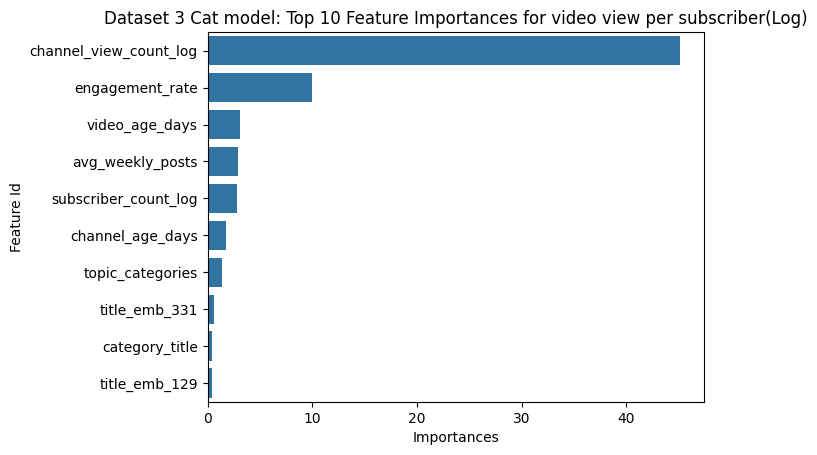

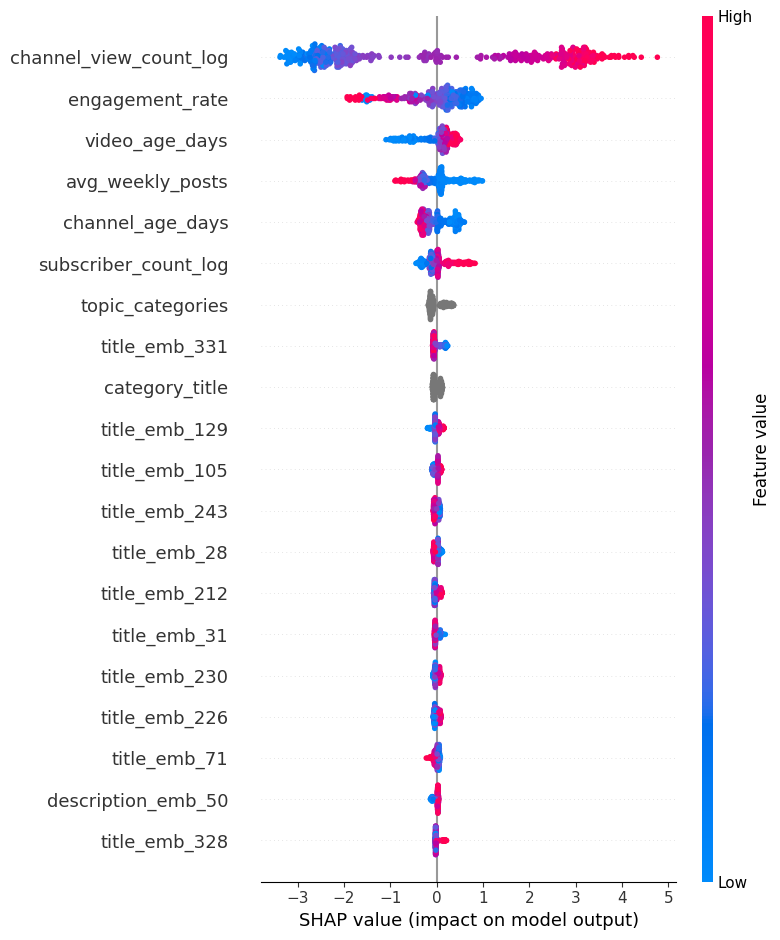

In [147]:
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_cols)
test_pool = Pool(data=X_test, label=y_test,cat_features=categorical_cols)
cat_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=6,
                             eval_metric='R2',
                             l2_leaf_reg=6, 
                             random_seed=9,
                             logging_level='Silent',
                             early_stopping_rounds=50
                            
                        
                             )
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

# R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_test_pred)


mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse) 
print("R² Train:", r2_train)
print("R² Test:", r2_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  
feature_importance_df = cat_model.get_feature_importance(prettified=True)
feature_importance_df
feature_importance_df = feature_importance_df.sort_values(by='Importances', ascending=False)
sns.barplot(x='Importances', y='Feature Id', data=feature_importance_df.head(10) )
plt.title('Dataset 3 Cat model: Top 10 Feature Importances for video view per subscriber(Log)')
plt.show()

shap_values = cat_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test,title='Dataset3: SHAP Feature Importance for Video view counts')  




In [166]:
title_embedding_importance = feature_importance_df[
    feature_importance_df['Feature Id'].str.startswith('title_emb', na=False)
]['Importances'].sum()
print(title_embedding_importance)
description_embedding_importance = feature_importance_df[
    feature_importance_df['Feature Id'].str.startswith('description_emb', na=False)
]['Importances'].sum()
print(description_embedding_importance)

22.135450031038005
8.938892521726252


In [187]:
df.nlargest(30, 'title_emb_331')[['video_title', 'video_view_count', 'title_emb_131']]


,video_title,video_view_count,title_emb_131
90,this japanese concept changed my perspective,3,0.005265
985,set concept sunny bunny chinni order and dupli...,625,0.002728
1744,4 c concepts you must know before dsa javascri...,407,0.042998
1875,javascript concepts every developer should kno...,13712,0.083857
85,javascript is a programming language for oop c...,6,-0.027040
1336,timing function javascript coder programmingla...,195,-0.046400
1008,arrow function js coding programming concepts ...,905,-0.050359
514,11 answer concept and vocabulary problems abou...,326,-0.011677
579,palindromes were tricky until i learned this,232563,-0.053503
1881,lil tecca reaction so funnyforyoufypdripeditfo...,11138,-0.012431


In [189]:
feature_importance_df.head(30)

,Feature Id,Importances
0,channel_view_count_log,45.122995
1,engagement_rate,9.950079
2,video_age_days,3.134084
3,avg_weekly_posts,2.930389
4,subscriber_count_log,2.833000
5,channel_age_days,1.780976
6,topic_categories,1.386605
7,title_emb_331,0.625009
8,category_title,0.439794
9,title_emb_129,0.430691


In [176]:
shap_values.shape[1]

794

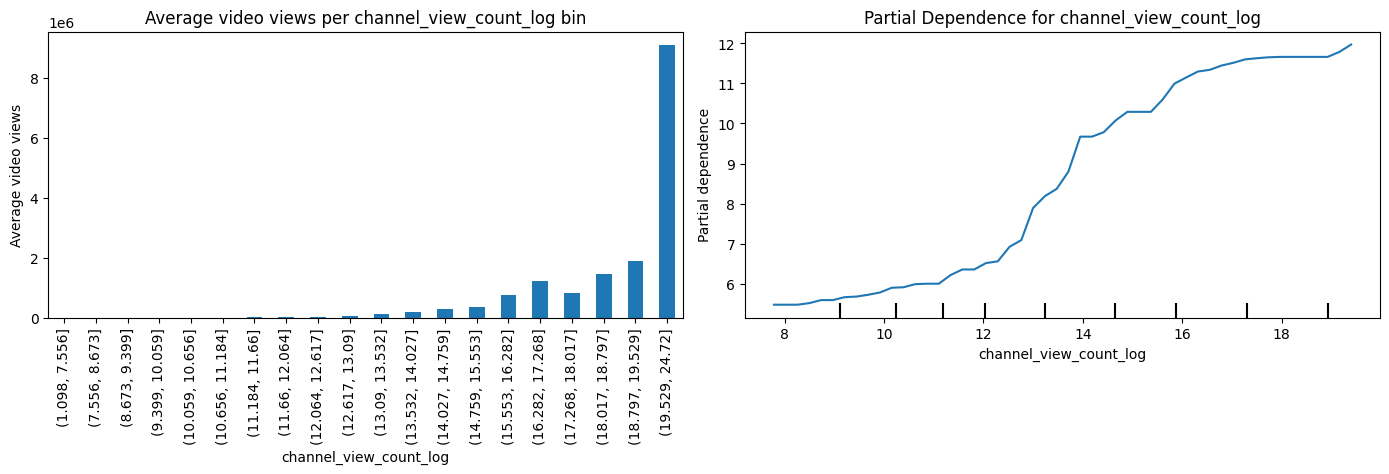

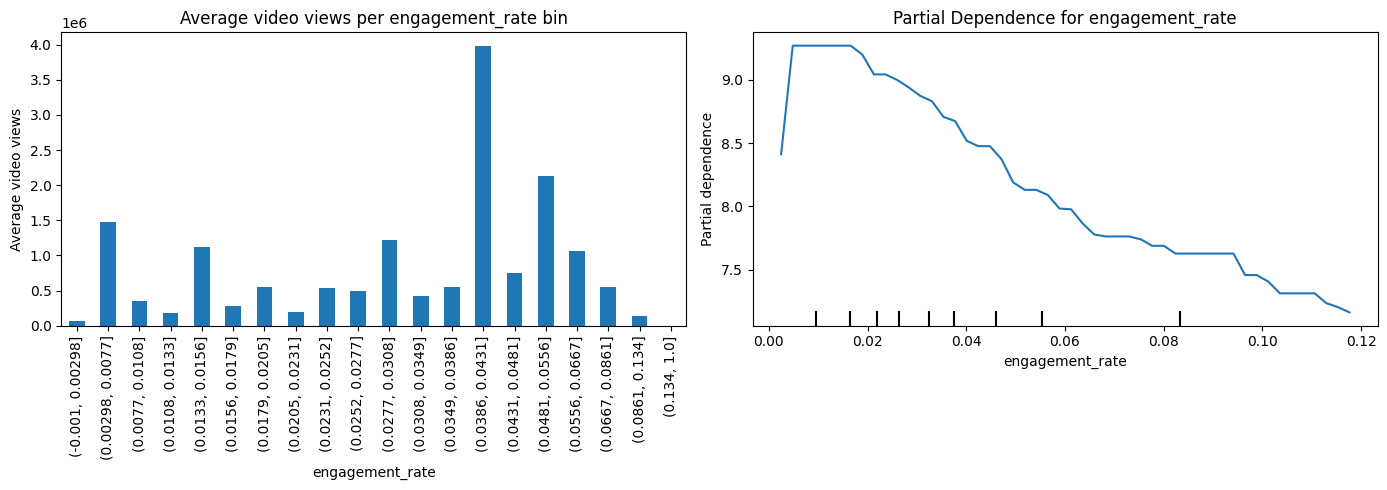

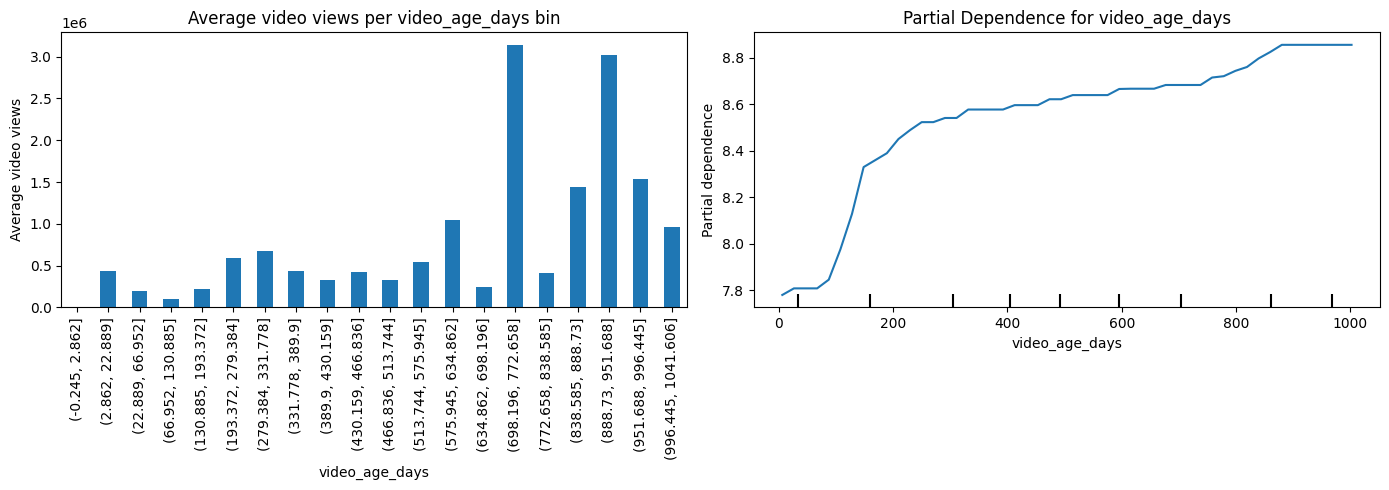

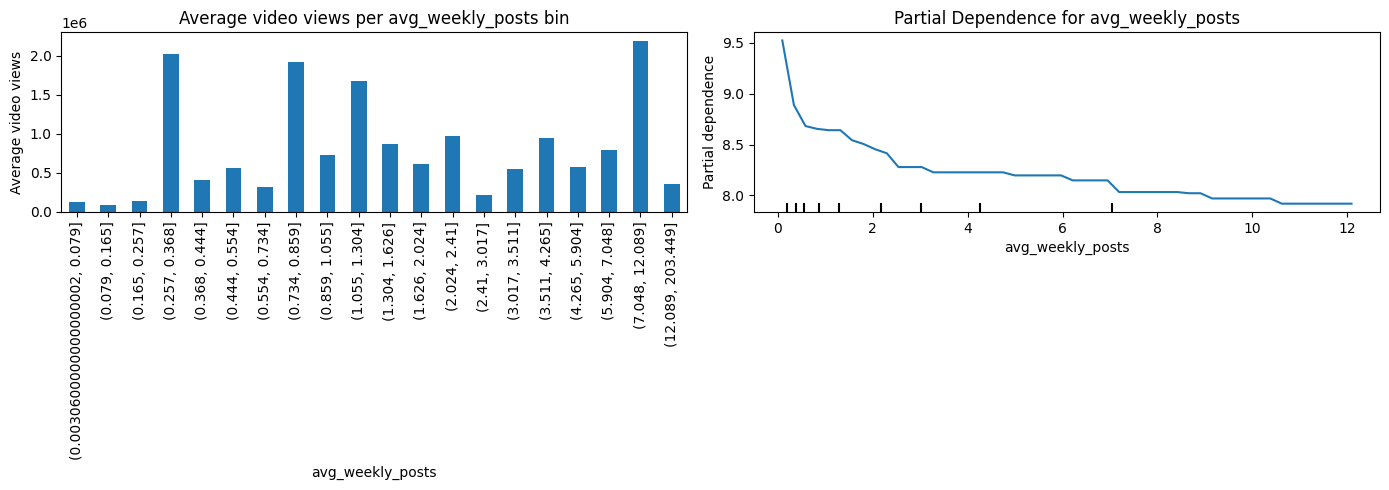

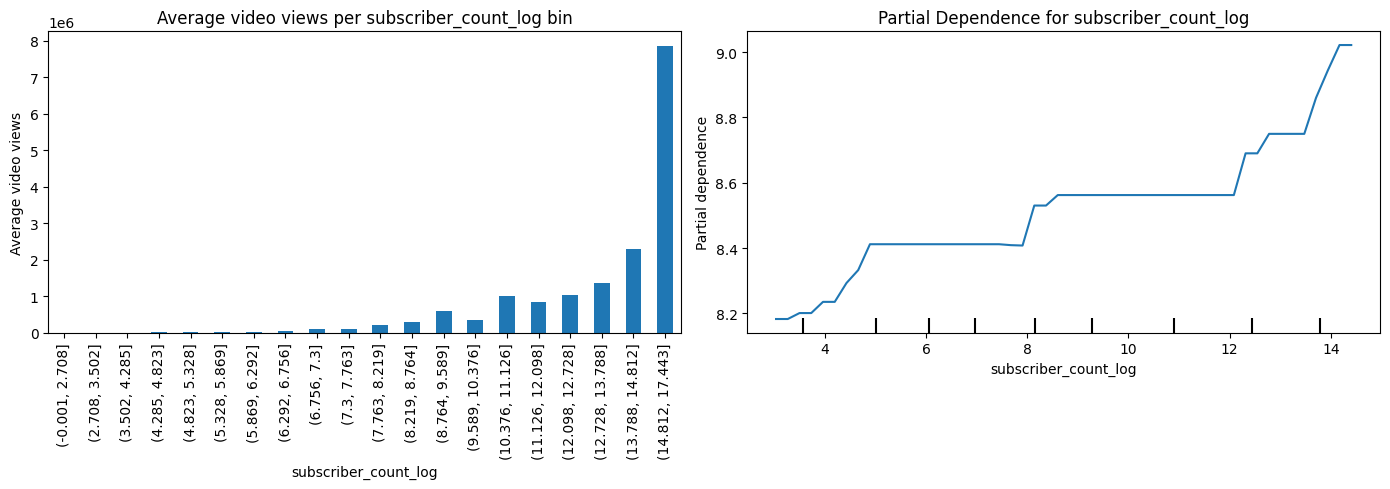

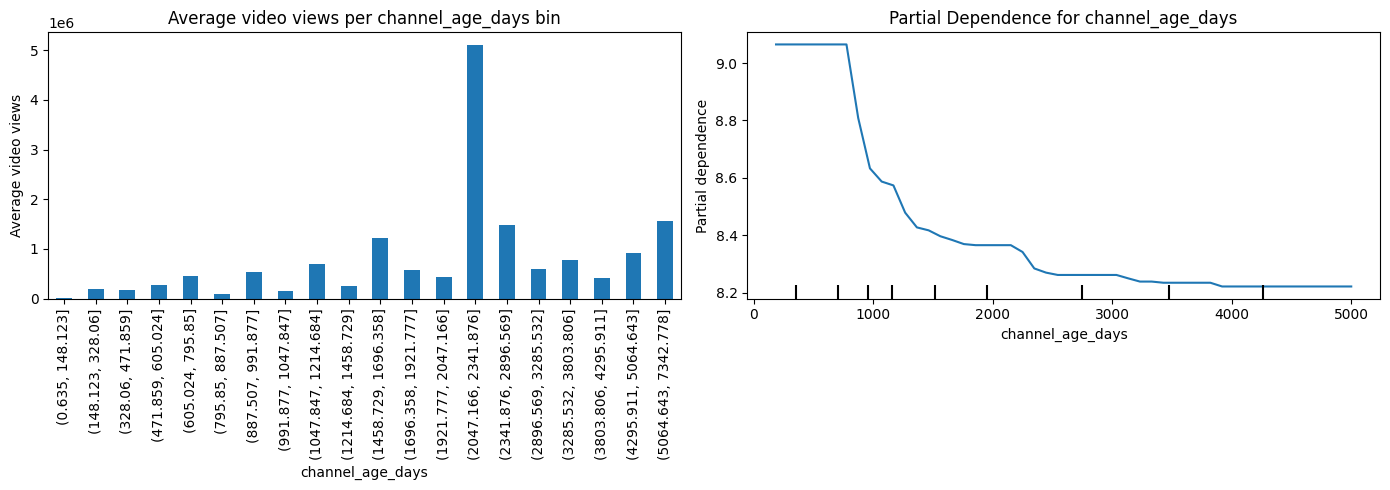

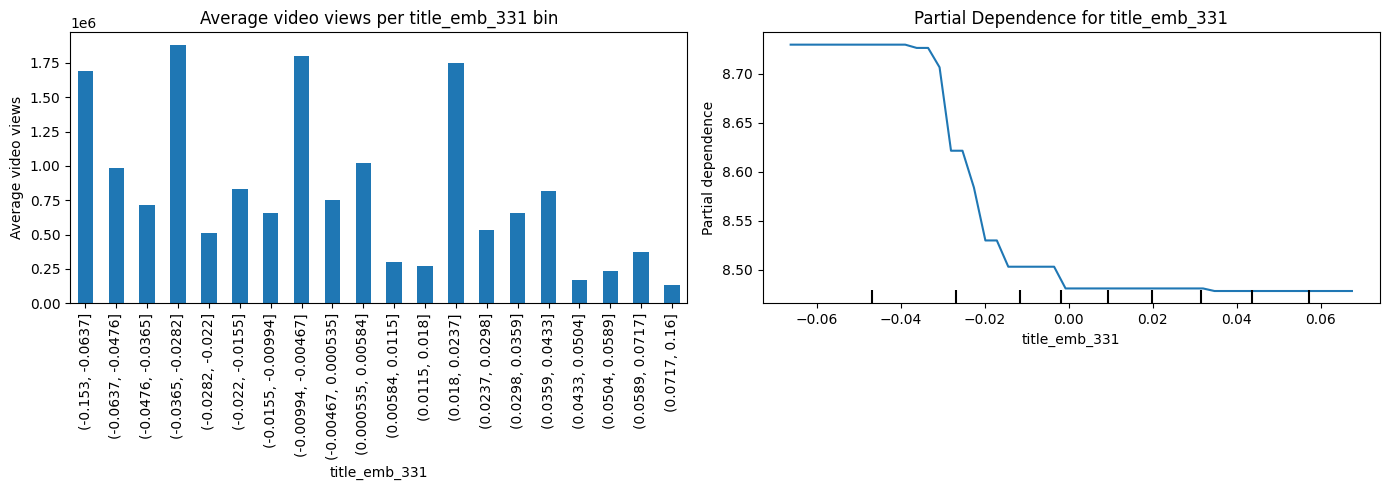

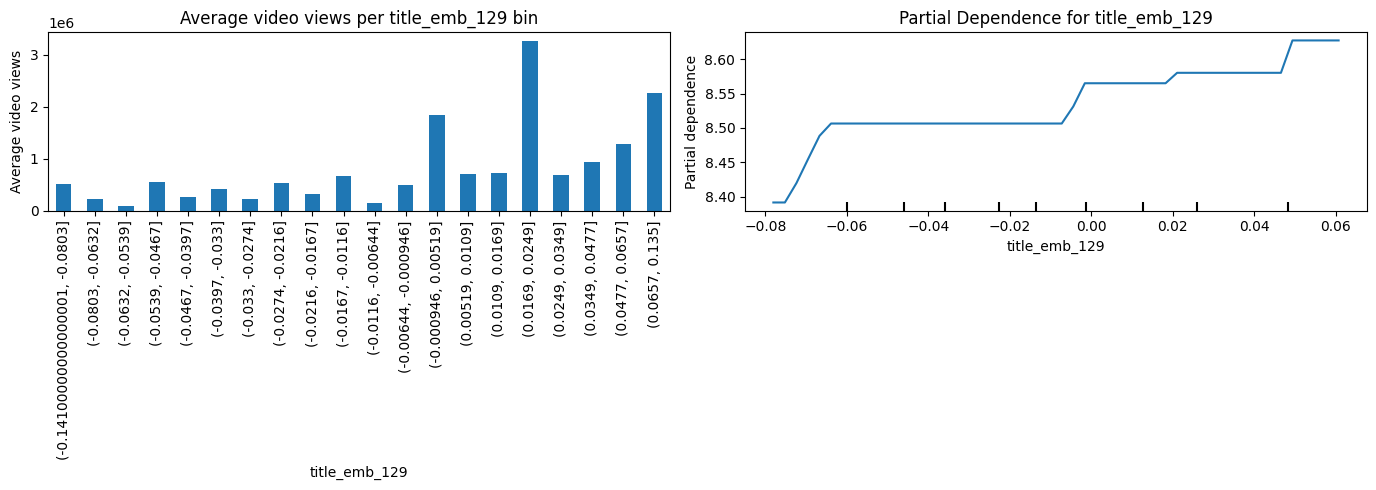

In [ ]:

from sklearn.inspection import PartialDependenceDisplay

top_10_features = feature_importance_df['Feature Id'].head(10)
top_10_numeric_features = [feature for feature in top_10_features if np.issubdtype(df[feature].dtype, np.number)]
for feature in top_10_numeric_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

    df[f'{feature}_bin'] = pd.qcut(df[feature], q=20, duplicates='drop')
    avg_values = df.groupby(f'{feature}_bin')['video_view_count'].mean()
    avg_values.plot(kind='bar', ax=axes[0])
    axes[0].set_title(f"Average video views per {feature} bin")
    axes[0].set_ylabel('Average video views')
    axes[0].set_xlabel(feature)

    PartialDependenceDisplay.from_estimator(
        cat_model, X_test, [feature], ax=axes[1], grid_resolution=50
    )
    axes[1].set_title(f"Partial Dependence for {feature}")

    plt.tight_layout()
    plt.show()
